# White-box Attack on CIFAR10

In [1]:
import sys

import torch
import torch.nn as nn

sys.path.insert(0, '..')
import torchattacks

## Load model and data

In [19]:
# imports
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn import CrossEntropyLoss
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from utils.metrics import topk_acc, real_acc, AverageMeter
from utils.parsers import get_training_parser
from utils.optimizer import get_optimizer, get_scheduler, OPTIMIZERS_DICT, SCHEDULERS

from models.networks import get_model
from data_utils.data_stats import *

import matplotlib.pyplot as plt
import argparse
import time

In [20]:
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

torch.manual_seed(0)

In [21]:
dataset = 'cifar10'                 # One of cifar10, cifar100, stl10, imagenet or imagenet21
architecture = 'B_12-Wi_1024'
data_resolution = 32                # Resolution of data as it is stored
crop_resolution = 64                # Resolution of fine-tuned model (64 for all models we provide)
num_classes = CLASS_DICT[dataset]
eval_batch_size = 1024
checkpoint = 'in21k_cifar10'

In [23]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)

transform = transforms.Compose([
    transforms.Resize((crop_resolution, crop_resolution)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# cifar10_dataset_norm = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# loader = DataLoader(cifar10_dataset_norm, batch_size=500, shuffle=False)

In [24]:
torch.backends.cuda.matmul.allow_tf32 = True

model = get_model(architecture=architecture, resolution=crop_resolution, num_classes=num_classes, checkpoint=checkpoint)
model.eval()

Weights already downloaded
Load_state output <All keys matched successfully>


BottleneckMLP(
  (linear_in): Linear(in_features=12288, out_features=1024, bias=True)
  (linear_out): Linear(in_features=1024, out_features=10, bias=True)
  (blocks): ModuleList(
    (0-11): 12 x BottleneckBlock(
      (block): Sequential(
        (0): Linear(in_features=1024, out_features=4096, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=4096, out_features=1024, bias=True)
      )
    )
  )
  (layernorms): ModuleList(
    (0-11): 12 x LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
)

In [36]:
sys.path.insert(0, '..')
import robustbench
from robustbench.data import load_cifar10
from robustbench.utils import load_model, clean_accuracy

images, labels = load_cifar10(n_examples=500, transforms_test=transform)
print('[Data loaded]')

device = "cpu"
# model = load_model('Standard', norm='Linf').to(device)
acc = clean_accuracy(model, images.to(device).flatten(1), labels.to(device))
print('[Model loaded]')
print('Acc: %2.2f %%'%(acc*100))

Files already downloaded and verified
[Data loaded]
[Model loaded]
Acc: 94.20 %


## Adversarial Attack

In [37]:
from torchattacks import PGD
from utils_attack import *

In [ ]:
class MLP_Wrapper(nn.Module):
    def __init__(self, architecture, resolution, num_classes, checkpoint):
        super(MLP_Wrapper, self).__init__()
        self.model = get_model(architecture=architecture, resolution=crop_resolution, num_classes=num_classes, checkpoint=checkpoint)

    def forward(self, x):
        x = x.flatten(1)
        x = self.model(x)
        return x

In [93]:
model = MLP_Wrapper(architecture, crop_resolution, num_classes, checkpoint)
model.eval()

Weights already downloaded
Load_state output <All keys matched successfully>


MLP_Wrapper(
  (model): BottleneckMLP(
    (linear_in): Linear(in_features=12288, out_features=1024, bias=True)
    (linear_out): Linear(in_features=1024, out_features=10, bias=True)
    (blocks): ModuleList(
      (0-11): 12 x BottleneckBlock(
        (block): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
    )
    (layernorms): ModuleList(
      (0-11): 12 x LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
  )
)

In [94]:
atk = PGD(model, eps=8/255, alpha=2/225, steps=10, random_start=True)
print(atk)

PGD(model_name=MLP_Wrapper, device=cpu, attack_mode=default, targeted=False, normalization_used=False, eps=0.03137254901960784, alpha=0.008888888888888889, steps=10, random_start=True)


In [95]:
# When normalization used:
atk.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [97]:
adv_images = atk(images, labels)

In [63]:
images.flatten(1).shape

torch.Size([500, 12288])

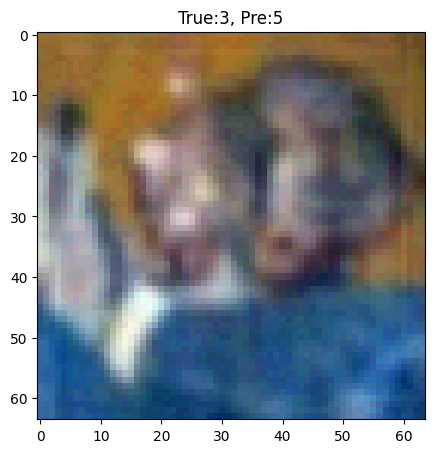

In [99]:
idx = 0
pre = get_pred(model, adv_images[idx:idx+1].flatten(1), device)
imshow(adv_images[idx:idx+1], title="True:%d, Pre:%d"%(labels[idx], pre))